In [45]:
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torch import nn
import random
import torch
import json
import os
import matplotlib.pyplot as plt
import sacrebleu
from utils import gen_padding_mask, random_change_idx, metrics, random_masked, random_mask_target, compute_length_loss, compute_levenshtein_loss
from seq2seqmodel import TransformerAutoEncoder
import numpy as np
from tokenizer import Tokenizer

In [46]:
# 檢查是否可用 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cuda':
    print(torch.cuda.get_device_name(device))
    print(torch.cuda.get_device_properties(device))

    # 清除 CUDA 設備的未使用內存
    torch.cuda.empty_cache()
else:
    print("CUDA is not available. Using CPU.")

NVIDIA GeForce RTX 4070 SUPER
_CudaDeviceProperties(name='NVIDIA GeForce RTX 4070 SUPER', major=8, minor=9, total_memory=12281MB, multi_processor_count=56, uuid=25c21ef8-cd11-c18b-4083-56f7752b9683, L2_cache_size=48MB)


In [47]:
class SpellCorrectionDataset(Dataset):
    def __init__(self, root, split, tokenizer, padding:int =24):
        super(SpellCorrectionDataset, self).__init__()

        with open(os.path.join(root, f'{split}.json'), 'r') as f:
            self.data = json.load(f)
        self.tokenizer = tokenizer
        self.padding = padding

    def tokenize(self, word):
        token_ids = [self.tokenizer.char_2_index['[sos]']] + \
                    self.tokenizer.char_to_index(word) + \
                    [self.tokenizer.char_2_index['[eos]']]
        
        # 填充或截斷序列至 padding 長度
        token_ids = token_ids[:self.padding]  # 截斷
        padded_ids = np.pad(token_ids, (0, max(0, self.padding - len(token_ids))), constant_values=self.tokenizer.pad_idx)
        
        return padded_ids
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        input_text = random.choice(sample['input'])  # 隨機選取一個輸入文本
        target_text = sample['target']  # 獲取目標文本
        
        # 將輸入和目標文本轉換為 token id 序列
        src_ids = torch.tensor(self.tokenize(input_text), dtype=torch.long)
        tgt_ids = torch.tensor(self.tokenize(target_text), dtype=torch.long)

        return src_ids, tgt_ids

In [48]:
tokenizer = Tokenizer()

PAD_IDX = tokenizer.pad_idx
SOS_IDX = tokenizer.sos_idx
EOS_IDX = tokenizer.eos_idx
MASK_IDX = tokenizer.mask_idx

In [64]:
def calculate_bleu(predictions, targets):
    # 計算 BLEU 分數
    predictions = [' '.join(list(pred)) for pred in predictions]
    targets = [' '.join(list(target)) for target in targets]
    bleu_score = sacrebleu.corpus_bleu(predictions, [targets]).score
    return bleu_score

def validation(dataloader, model, criterion, logout=False):
    pred_str_list = []
    tgt_str_list = []
    input_str_list = []
    total_loss = 0.0
    total_accuracy = 0.0

    model.eval()
    with torch.no_grad():
        for src_ids, tgt_ids in dataloader:
            src_ids, tgt_ids = src_ids.to(device), tgt_ids.to(device)
            tgt_ids_masked = torch.full_like(tgt_ids, fill_value=PAD_IDX)
            tgt_ids_masked[:, 0] = SOS_IDX  # 初始化 tgt_input

            src_pad_mask = gen_padding_mask(src_ids, pad_idx=PAD_IDX)
            tgt_pad_mask = gen_padding_mask(tgt_ids_masked, pad_idx=PAD_IDX)

            output = model(src_ids, tgt_ids_masked, src_pad_mask, tgt_pad_mask)

            pred = output.argmax(dim=-1)  # [batch_size, sequence_length]
            pred_str_batch = [
                tokenizer.index_to_char(pred[i], without_token=True)
                for i in range(pred.size(0))
            ]
            target_str_batch = [
                tokenizer.index_to_char(tgt_ids[i], without_token=True)
                for i in range(tgt_ids.size(0))
            ]
            input_str_batch = [
                tokenizer.index_to_char(src_ids[i], without_token=True)
                for i in range(src_ids.size(0))
            ]

            # 批量加入列表
            pred_str_list.extend(pred_str_batch)
            tgt_str_list.extend(target_str_batch)
            input_str_list.extend(input_str_batch)

            if logout:
                print('='*30)
                print(f'input: {input_str_list[-1]}')
                print(f'pred: {pred_str_list[-1]}')
                print(f'target: {tgt_str_list[-1]}')

                
            ce_loss = criterion(output.view(-1, output.size(-1)), tgt_ids.view(-1))
            length_loss = compute_length_loss(pred, tgt_ids, EOS_IDX)
            levenshtein_loss = compute_levenshtein_loss(pred_str_batch, target_str_batch)
            loss = ce_loss + 0.1 * length_loss + 0.5 * levenshtein_loss
            total_loss += loss.item()
            total_accuracy += metrics(pred_str_batch, target_str_batch)

    bleu_score = calculate_bleu(pred_str_list, tgt_str_list)
    total_loss /= len(dataloader)
    total_accuracy /= len(dataloader)

    return total_loss, total_accuracy, bleu_score

In [50]:
def train(model, trainloader, valloader, criterion, optimizer, scheduler, epochs, change_prob, mask_prob, logout=False):
    train_loss_history = []
    val_loss_history = []
    val_acc_history = []
    bleu_score_history = []

    
    for epoch in range(epochs):
        # train
        train_loss = 0.0
        model.train()

        for src_ids, tgt_ids in trainloader:
            src_ids, tgt_ids = src_ids.to(device), tgt_ids.to(device)

            src_ids = random_change_idx(src_ids.clone(), prob=change_prob, pad_idx=PAD_IDX).to(device)
            src_ids = random_masked(src_ids.clone(), prob=mask_prob, mask_idx=MASK_IDX, pad_idx=PAD_IDX).to(device)

            # 遮蔽目標單字
            tgt_ids_masked = torch.full_like(tgt_ids, fill_value=PAD_IDX)
            tgt_ids_masked[:, 0] = SOS_IDX  # 初始化 tgt_input

            src_pad_mask = gen_padding_mask(src_ids, pad_idx=PAD_IDX).to(device)
            tgt_pad_mask = gen_padding_mask(tgt_ids_masked, pad_idx=PAD_IDX).to(device)

            optimizer.zero_grad()

            output = model(src_ids, tgt_ids_masked, src_pad_mask, tgt_pad_mask)
            pred = output.argmax(dim=-1) 

            ce_loss = criterion(output.view(-1, output.size(-1)), tgt_ids.view(-1))
            length_loss = compute_length_loss(pred, tgt_ids, EOS_IDX)

            pred_str_batch = [
                tokenizer.index_to_char(pred[i], without_token=True)
                for i in range(pred.size(0))
            ]
            target_str_batch = [
                tokenizer.index_to_char(tgt_ids[i], without_token=True)
                for i in range(tgt_ids.size(0))
            ]

            levenshtein_loss = compute_levenshtein_loss(pred_str_batch, target_str_batch)
            loss = ce_loss + 0.1 * length_loss + 0.5 * levenshtein_loss

            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(trainloader)
        train_loss_history.append(train_loss)

        # validation
        val_loss, val_acc, bleu_score = validation(valloader, model, criterion, logout=logout)

        scheduler.step(val_loss) 

        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        bleu_score_history.append(bleu_score)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}%, Bleu score: {bleu_score:.4f}')

    return train_loss_history, val_loss_history, val_acc_history, bleu_score_history

In [51]:
# 可視化結果
def plot_results(train_loss, val_loss, val_acc, bleu_score):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(val_acc, label='Validation Accuency')
    plt.xlabel('Epochs')
    plt.ylabel('Accuency')
    plt.legend()
    plt.title('Validation Accuency')
    plt.show()

    # Plot BLEU score
    plt.figure(figsize=(10, 5))
    plt.plot(bleu_score, label='BLEU Score')
    plt.xlabel('Epochs')
    plt.ylabel('BLEU Score')
    plt.legend()
    plt.title('Validation BLEU Score')
    plt.show()

In [52]:
checkpoint = torch.load('pretrain_para.pth')

# 使用配置初始化模型
config = checkpoint['model_config']
padding = config['max_length']

epochs=500
batch_size=32
learning_rate=0.0001
patience=5
factor=0.9
min_lr=1e-6

change_prob = 0.2
mask_prob = 0.1

C:\Users\wei\AppData\Local\Temp\ipykernel_46848\3644785723.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('pretrain_para.pth')


In [53]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = TransformerAutoEncoder(**config).to(device)

# 載入權重
model.load_state_dict(checkpoint['model_state_dict'])

ce_loss = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_idx)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience, min_lr=min_lr, verbose=False)

c:\Users\wei\Desktop\programs\deep learning\test\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [54]:
full_trainset = SpellCorrectionDataset('./data/', split='train', tokenizer=tokenizer, padding=padding)
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])


train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False)

testset = SpellCorrectionDataset('./data/', split='test', tokenizer=tokenizer, padding=padding)
new_testset = SpellCorrectionDataset('./data/', split='new_test', tokenizer=tokenizer, padding=padding)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
new_testloader = DataLoader(new_testset, batch_size=batch_size, shuffle=False)

In [55]:
train_loss, val_loss, val_acc, bleu_score = train(
    model=model,
    trainloader=train_loader,
    valloader=val_loader,
    criterion=ce_loss,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=epochs,
    change_prob=mask_prob,
    mask_prob=mask_prob,
    logout=False
)

Epoch [1/500], Train Loss: 3.0445, Val Loss: 1.0287, Val Acc: 1.5293%, Bleu score: 52.9507
Epoch [2/500], Train Loss: 2.9123, Val Loss: 0.9938, Val Acc: 3.1250%, Bleu score: 52.6082
Epoch [3/500], Train Loss: 2.8590, Val Loss: 0.9580, Val Acc: 3.3910%, Bleu score: 53.0543
Epoch [4/500], Train Loss: 2.8456, Val Loss: 0.9531, Val Acc: 4.9202%, Bleu score: 51.4889
Epoch [5/500], Train Loss: 2.8015, Val Loss: 0.9470, Val Acc: 5.0532%, Bleu score: 50.7716
Epoch [6/500], Train Loss: 2.7935, Val Loss: 0.9226, Val Acc: 7.1144%, Bleu score: 53.1094
Epoch [7/500], Train Loss: 2.7526, Val Loss: 0.9167, Val Acc: 6.3165%, Bleu score: 52.7730
Epoch [8/500], Train Loss: 2.7423, Val Loss: 0.9081, Val Acc: 7.0827%, Bleu score: 52.4594
Epoch [9/500], Train Loss: 2.7287, Val Loss: 0.9007, Val Acc: 7.9122%, Bleu score: 51.6120
Epoch [10/500], Train Loss: 2.7074, Val Loss: 0.9129, Val Acc: 7.6494%, Bleu score: 53.5172
Epoch [11/500], Train Loss: 2.6809, Val Loss: 0.9076, Val Acc: 9.0109%, Bleu score: 54.50

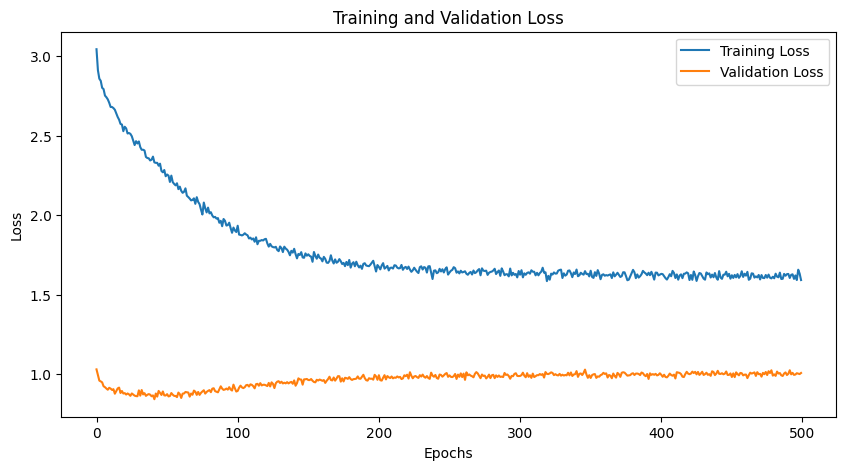

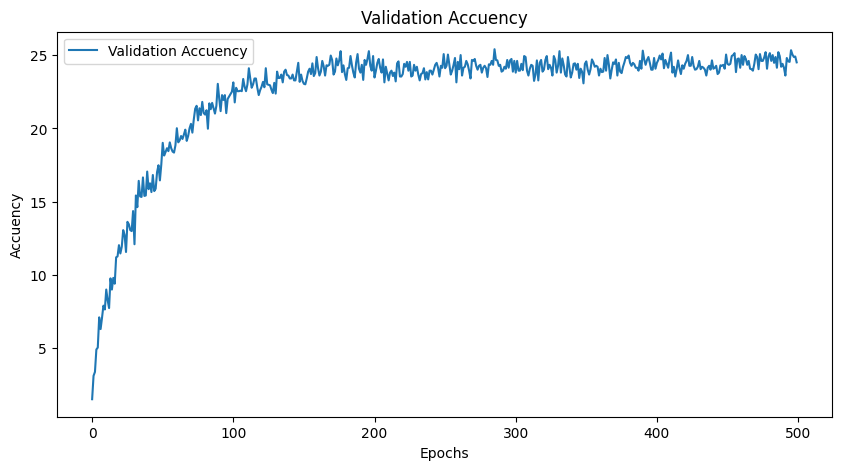

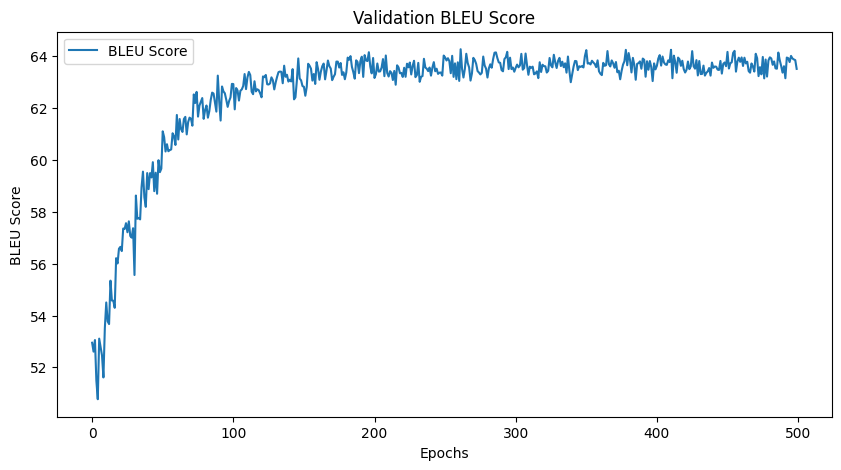

In [56]:
plot_results(train_loss, val_loss, val_acc, bleu_score)

In [67]:
print('Test Dataset: ')
total_loss, total_accuracy, bleu_score = validation(test_loader, model, ce_loss, logout=True)
print(f'Loss: {total_loss:.4f}, Acc: {total_accuracy:.4f}%, Bleu score: {bleu_score:.4f}')

Test Dataset: 
input: dag
pred: dog
target: dog
input: scadual
pred: scheduee
target: schedule
Loss: 0.5961, Acc: 69.2708%, Bleu score: 86.0457


In [68]:
print('New Test Dataset: ')
total_loss, total_accuracy, bleu_score = validation(new_testloader, model, ce_loss, logout=True)
print(f'Loss: {total_loss:.4f}, Acc: {total_accuracy:.4f}%, Bleu score: {bleu_score:.4f}')

New Test Dataset: 
input: beest
pred: beesst
target: best
input: visable
pred: visible
target: visible
Loss: 1.7276, Acc: 29.1667%, Bleu score: 64.0418
